In [1]:
import pandas as pd
import json
from datetime import datetime, timedelta
import numpy as np
from scipy.integrate import odeint
from decimal import Decimal

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# popolazione per regione

regioni_popolazione = {
    "Lombardia": 10.06e6,
    "Lazio": 5.87e6,
    "Campania": 5.80e6,
    "Sicilia": 4.99e6,
    "Veneto": 4.905854e6,
    "Emilia Romagna": 4.459477e6,
    "Piemonte": 4.356406e6,
    "Puglia": 4.029053e6,
    "Toscana": 3.729641e6,
    "Calabria": 1.947131e6,
    "Sardegna": 1.639591e6,
    "Liguria": 1.550640e6,
    "Marche": 1.525271e6,
    "Abruzzo": 1.311580e6,
    "Friuli Venezia Giulia": 1.215220e6,
    "Trentino-Alto Adige": 1.072276e6,
    "Umbria": 0.882015e6,
    "Basilicata": 0.562869e6,
    "Molise": 0.305617e6,
    "Valle d'Aosta": 0.125666e6
}

In [2]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [15]:
with open("./COVID-19/dati-json/dpc-covid19-ita-regioni.json") as f:
        dataset = json.load(f)
        
regioni = {}
regioni_days = {}
regioni_guariti = {}

for item in dataset:
    if (item['denominazione_regione'] not in regioni.keys()):
        regioni[item['denominazione_regione']] = []
        regioni_guariti[item['denominazione_regione']] = []
        regioni_days[item['denominazione_regione']] = []
        
    regioni[item['denominazione_regione']].append(item['totale_casi'])
    regioni_guariti[item['denominazione_regione']].append(item['dimessi_guariti'])
    
    #convert to datetime
    regioni_days[item['denominazione_regione']].append(datetime.strptime(item['data'], '%Y-%m-%d %H:%M:%S'))

In [85]:
regione_di_interesse = 'Lombardia'
N = regioni_popolazione[regione_di_interesse]

In [86]:
# Initial number of infected and recovered individuals (in date 2-24-2020)

I0 = regioni[regione_di_interesse][0]
R0 = regioni_guariti[regione_di_interesse][0]
        
# Number of people susceptible to infection initially.
S0 = N - I0 - R0

# Initial conditions vector
y0 = S0, I0, R0

In [87]:
t = np.linspace(0, len(regioni_days[regione_di_interesse]), len(regioni_days[regione_di_interesse]))

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta_low = 0.27
gamma_low = 1./15.

R0_low =  beta_low/gamma_low

print("R0_low:", round(R0_low, 4))

#herd_immune threshold
print("HIT low:",  round(1. - (1/R0_low), 3))

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta_low, gamma_low))
S_low, I_low, R_low = ret.T

beta_high = 0.275
gamma_high = 1./15.

R0_high =  beta_high/gamma_high

print("R0_high:", round(R0_high, 4))
print("HIT high:",  round(1. - (1/R0_high), 3))

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta_high, gamma_high))
S_high, I_high, R_high = ret.T

R0_low: 4.05
HIT low: 0.753
R0_high: 4.125
HIT high: 0.758


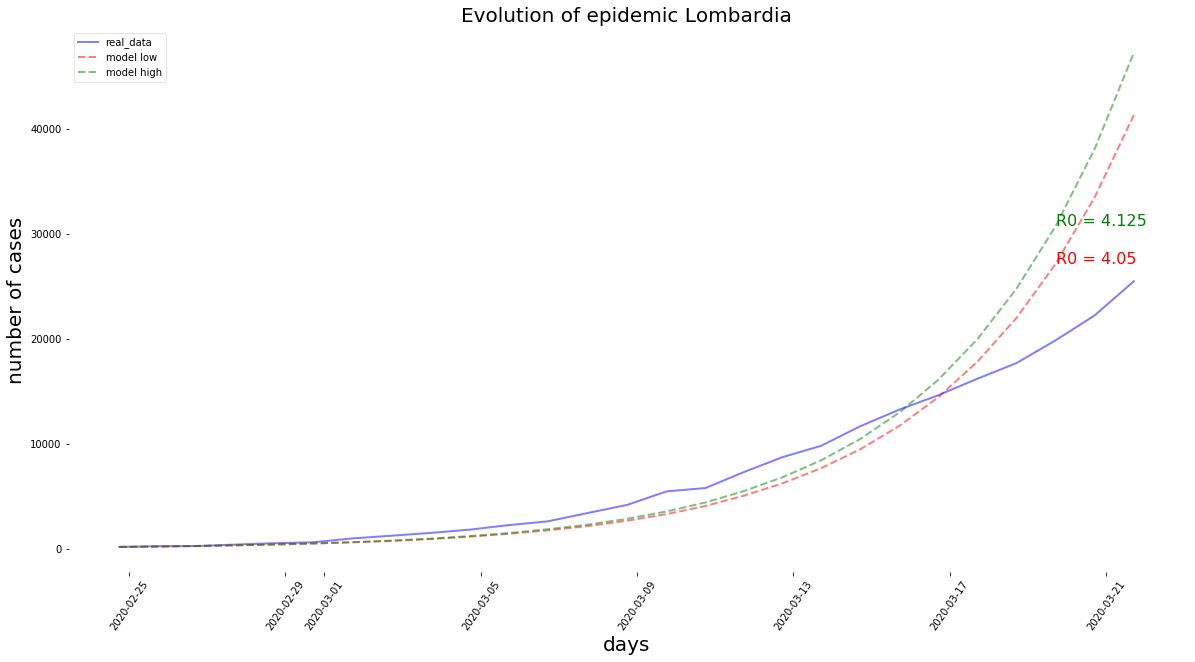

In [91]:


fig = plt.figure(facecolor='w', figsize=(20,10))

ax = fig.add_subplot(111, axisbelow=True)

ax.plot(regioni_days[regione_di_interesse], regioni[regione_di_interesse], 'b', alpha=0.5, lw=2, label='real_data')
ax.plot(regioni_days[regione_di_interesse], I_low, 'r', alpha=0.5, lw=2, label='model low', linestyle='dashed')
ax.plot(regioni_days[regione_di_interesse], I_high, 'g', alpha=0.5, lw=2, label='model high', linestyle='dashed')

ax.text(regioni_days[regione_di_interesse][-3], I_low[-3], "R0 = " + str(round(R0_low, 4)), fontsize=16,
               rotation=0, rotation_mode='anchor', color='red')

ax.text(regioni_days[regione_di_interesse][-3], I_high[-3], "R0 = " + str(round(R0_high, 4)), fontsize=16,
               rotation=0, rotation_mode='anchor', color='green')


#ax.plot(t, num_casi, 'b', alpha=0.5, lw=2, label='real_data')
#ax.plot(t, I_low, 'r', alpha=0.5, lw=2, label='model low')
#ax.plot(t, I_high, 'g', alpha=0.5, lw=2, label='model high')

plt.title('Evolution of epidemic ' + regione_di_interesse, fontsize=20)

ax.set_xlabel('days', fontsize=20)
ax.set_ylabel('number of cases', fontsize=20)

#plt.xticks(rotation=90)

ax.xaxis.set_tick_params(rotation=55)

#ax.yaxis.set_tick_params(length=0)
#ax.xaxis.set_tick_params(length=0)

ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.savefig("images/evolution_" + regione_di_interesse + "_" + str(regioni_days[regione_di_interesse][-1].date()) +".png")
#plt.show()